In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///C:/Users/Piotrek/Documents/Inzynierka/csgo-analysis/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil


from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, \
        f1_score, RocCurveDisplay, roc_auc_score, make_scorer
from functools import partial
from sklearn.calibration import CalibrationDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold, train_test_split

# Wczytanie danych

In [3]:
def select_feat():
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return columns

In [4]:
df = pd.read_parquet('data/ESTA_states_prepared.parquet', columns=select_feat() + ['demoId', 'roundNum'])
df

,seconds,ctAlivePlayers,ctEqVal,tAlivePlayers,tEqVal,ct_armor,t_armor,ct_hp,t_hp,ct_hasHelmet,...,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted,demoId,roundNum
0,0.007874,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
1,0.511811,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
2,1.015748,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
3,1.519685,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
4,2.023622,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464293,81.464567,3,26800,1,24300,290,94,233,74,3,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464294,81.968504,3,26800,1,24300,290,94,233,74,3,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464295,82.472441,3,26800,1,24300,286,94,206,74,3,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464296,82.976378,2,26800,1,24300,194,94,159,74,2,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464298 entries, 0 to 7464297
Columns: 101 entries, seconds to roundNum
dtypes: float64(17), int32(6), int64(67), object(1), uint8(10)
memory usage: 5.0+ GB


In [6]:
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()
y

0          0
1          0
2          0
3          0
4          0
          ..
7464293    1
7464294    1
7464295    1
7464296    1
7464297    1
Name: winningSideCT, Length: 7464298, dtype: int32

## Podział

In [ ]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = groupped.indices
np.random.seed(25)
samples_indexes = [values[np.random.randint(1, values.size)]
                  for key, values in demo_indexes.items()]
len(samples_indexes)

41074

In [ ]:
X = df.drop(['demoId', 'roundNum'], axis='columns').iloc[samples_indexes]
y = y.iloc[samples_indexes]
X.shape, y.shape

((41074, 99), (41074,))

In [ ]:
y.value_counts()

1    22158
0    18916
Name: winningSideCT, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # 0.125 x 0.8 = 0.1
X_train.shape, X_val.shape, X_test.shape

((28751, 99), (4108, 99), (8215, 99))

In [11]:
y_test.value_counts(normalize=True)

1    0.541327
0    0.458673
Name: winningSideCT, dtype: float64

In [12]:
parameters = {
    "max_leaves": Integer(0, 70),
    "max_depth": Integer(2, 80),
    "n_estimators": Integer(100, 1300),
    "subsample": Real(0.6, 1),
}

opt = BayesSearchCV(xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0),
                    search_spaces=parameters,
                    scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True, eps=1e-7),
                    n_iter=50,
                    fit_params={"eval_set": [(X_val, y_val)]},
                    cv=StratifiedKFold(n_splits=3),
                    n_jobs=3,
                    verbose=1,
                    random_state=42)
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=0, grow_policy=None,
                                      importance_ty...
              scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True, eps=1e-07),
              search_spaces={'max_depth': Integer(low=2, high=80, prior='uniform', transform='normalize'),
                             'max_leaves': Integer(low=0, high=70, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1300, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize')},
              verbose=1)

In [13]:
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaves,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,19.479600,0.078178,0.075983,1.228122e-03,34,51,1219,0.72632,"{'max_depth': 34, 'max_leaves': 51, 'n_estimat...",-0.786480,-0.809099,-0.803842,-0.799807,0.009665,50
8,16.283230,0.014079,0.078572,1.022120e-03,77,49,1146,0.766328,"{'max_depth': 77, 'max_leaves': 49, 'n_estimat...",-0.763625,-0.797971,-0.784791,-0.782129,0.014147,49
10,15.255039,0.035064,0.073421,1.881323e-03,26,58,998,0.744972,"{'max_depth': 26, 'max_leaves': 58, 'n_estimat...",-0.762589,-0.759779,-0.793579,-0.771982,0.015314,48
7,11.677206,0.005887,0.059468,1.242966e-03,44,64,696,0.935063,"{'max_depth': 44, 'max_leaves': 64, 'n_estimat...",-0.706645,-0.725771,-0.727097,-0.719838,0.009344,47
29,19.640864,0.097004,0.082059,2.348816e-03,56,0,828,1.0,"{'max_depth': 56, 'max_leaves': 0, 'n_estimato...",-0.707857,-0.724463,-0.726679,-0.719666,0.008399,46
43,12.711812,0.035474,0.059800,1.627230e-03,16,0,533,0.6,"{'max_depth': 16, 'max_leaves': 0, 'n_estimato...",-0.710237,-0.726256,-0.719261,-0.718585,0.006557,45
22,14.947645,0.058988,0.065802,2.653201e-03,80,0,546,1.0,"{'max_depth': 80, 'max_leaves': 0, 'n_estimato...",-0.679733,-0.697649,-0.698289,-0.691890,0.008600,44
41,14.029264,0.031730,0.060132,1.694500e-03,66,0,461,1.0,"{'max_depth': 66, 'max_leaves': 0, 'n_estimato...",-0.670106,-0.686237,-0.687491,-0.681278,0.007916,43
36,9.372140,0.011009,0.043853,1.123916e-07,6,67,878,1.0,"{'max_depth': 6, 'max_leaves': 67, 'n_estimato...",-0.651193,-0.672676,-0.667522,-0.663797,0.009158,42
6,7.529959,0.035933,0.040200,2.046199e-03,50,54,531,0.94973,"{'max_depth': 50, 'max_leaves': 54, 'n_estimat...",-0.618875,-0.646929,-0.644046,-0.636617,0.012600,41


In [14]:
model_xgb = opt.best_estimator_
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


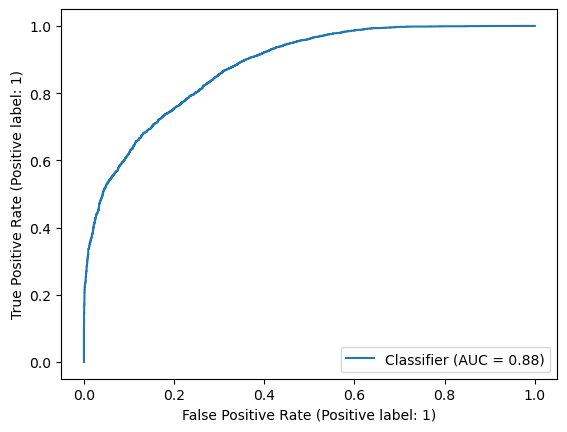

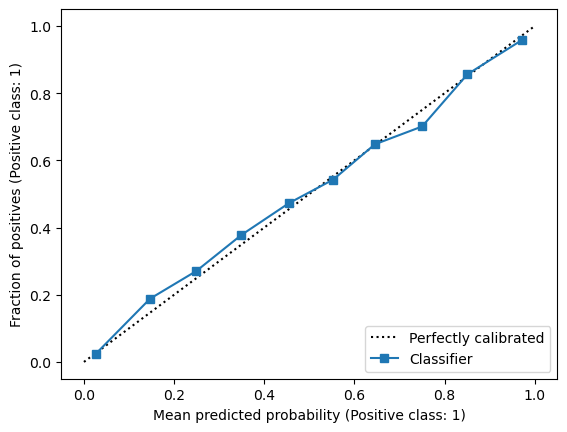

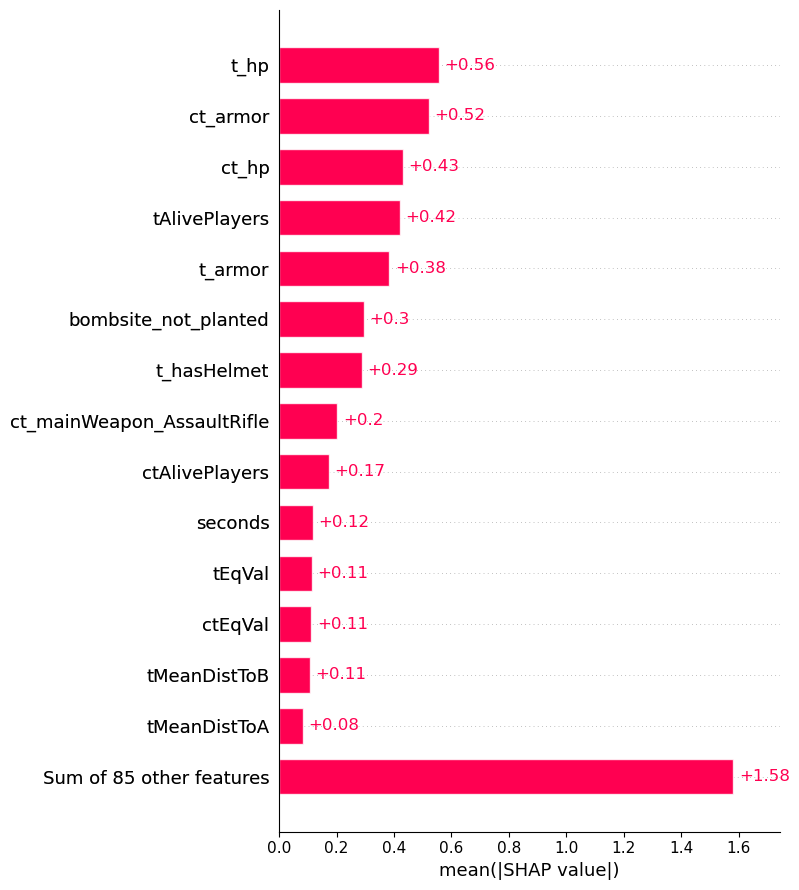

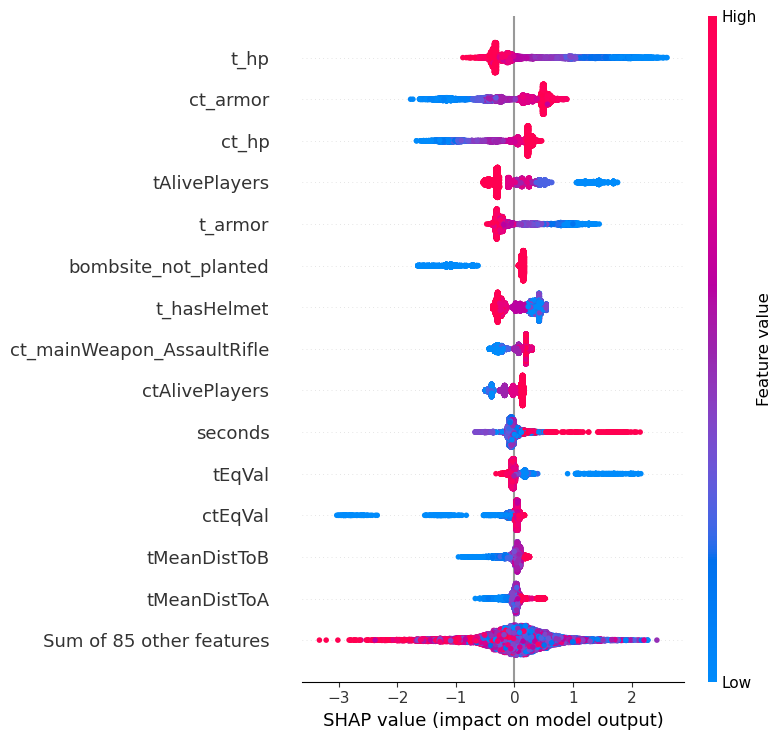

In [15]:
run_name = "XGB - ESTA improvement"
additional_description = "XGB ESTA improvement"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_xgb.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_xgb.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = X_train.columns.tolist()
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        os.makedirs('artifacts', exist_ok=True)
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        os.makedirs('models', exist_ok=True)
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_xgb, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [16]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [17]:
results = []
y_true = test_y
y_pred = model_xgb.predict_proba(test_df.drop("filename", axis="columns"))[:, 1]
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.4680170882572386,
 'LogLoss (future)': 0.4678280738954298,
 'LogLoss (past)': 0.46819333253202555,
 'AUC-ROC (all)': 0.8489730483326966,
 'AUC-ROC (future)': 0.8507050735791739,
 'AUC-ROC (past)': 0.8468949485609216}

In [24]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.540607
 0    0.459393
 Name: winningSideCT, dtype: float64,
 1    0.536801
 0    0.463199
 Name: winningSideCT, dtype: float64,
 1    0.535484
 0    0.464516
 Name: winningSideCT, dtype: float64)

# Większy sampling

## Podział

In [18]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = groupped.indices
np.random.seed(25)
how_many = 10
samples_indexes = {key: [values[np.random.randint(1, values.size)]
                   for i in range(how_many)]
                      for key, values in demo_indexes.items()}
len(samples_indexes)

41074

In [19]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.8*maps), replace=False)
train_indexes = np.array([])
test_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i not in train_ind:
        test_indexes = np.concatenate((test_indexes, samples_indexes[key]))

test_indexes.shape

(82150,)

In [20]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(train_ind, size=int(0.875*train_ind.size), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, samples_indexes[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, samples_indexes[key]))

train_indexes.shape, valid_indexes.shape

((287510,), (123230,))

In [21]:
X = df.drop(['demoId', 'roundNum'], axis='columns')
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()

In [22]:
y.value_counts()

1    3875902
0    3588396
Name: winningSideCT, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = X.iloc[train_indexes], X.iloc[test_indexes], y.iloc[train_indexes], y.iloc[test_indexes]
X_val, y_val = X.iloc[valid_indexes], y.iloc[valid_indexes]
X_train.shape, X_val.shape, X_test.shape

((287510, 99), (123230, 99), (82150, 99))

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    for col in X_train:
        print(col, X_train[col].isin([np.nan, np.inf, -np.inf]).sum())

seconds 0
ctAlivePlayers 0
ctEqVal 0
tAlivePlayers 0
tEqVal 0
ct_armor 0
t_armor 0
ct_hp 0
t_hp 0
ct_hasHelmet 0
t_hasHelmet 0
ct_DecoyGrenade 0
t_DecoyGrenade 0
ct_Flashbang 0
t_Flashbang 0
ct_HEGrenade 0
t_HEGrenade 0
ct_SmokeGrenade 0
t_SmokeGrenade 0
ct_fireGrenades 0
t_fireGrenades 0
ct_isBlinded 0
t_isBlinded 0
ct_hasDefuse 0
t_hasBomb 0
ct_isDefusing 0
t_isPlanting 0
ct_spottedPlayers 0
t_spottedPlayers 0
ct_grouppedPlayers 0
ct_meanDist 0
ct_minDist 0
t_meanDist 0
t_minDist 0
t_grouppedPlayers 0
ct_conquerMap 0
t_conquerMap 0
ct_activeWeapon_Pistol 0
ct_activeWeapon_EnhancedPistols 0
ct_activeWeapon_Deagle 0
ct_activeWeapon_SMG 0
ct_activeWeapon_WeakAssaultRifle 0
ct_activeWeapon_LunetRifle 0
ct_activeWeapon_SniperRifle 0
ct_activeWeapon_AssaultRifle 0
ct_activeWeapon_Others 0
t_activeWeapon_Pistol 0
t_activeWeapon_EnhancedPistols 0
t_activeWeapon_Deagle 0
t_activeWeapon_SMG 0
t_activeWeapon_WeakAssaultRifle 0
t_activeWeapon_LunetRifle 0
t_activeWeapon_SniperRifle 0
t_activeWea

In [26]:
parameters = {
    "max_leaves": Integer(0, 70),
    "max_depth": Integer(2, 80),
    "n_estimators": Integer(100, 1300),
    "subsample": Real(0.6, 1),
}

opt = BayesSearchCV(xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0),
                    search_spaces=parameters,
                    scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True, eps=1e-7),
                    n_iter=50,
                    fit_params={"eval_set": [(X_val, y_val)]},
                    cv=StratifiedKFold(n_splits=3),
                    n_jobs=1,
                    verbose=1,
                    random_state=42
                   )
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=0, grow_policy=None,
                                      importance_ty...
              scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True, eps=1e-07),
              search_spaces={'max_depth': Integer(low=2, high=80, prior='uniform', transform='normalize'),
                             'max_leaves': Integer(low=0, high=70, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1300, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize')},
              verbose=1)

In [27]:
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaves,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
21,28.241413,0.078397,0.580475,0.004539,61,0,1300,0.6,"{'max_depth': 61, 'max_leaves': 0, 'n_estimato...",-0.782879,-0.783279,-0.783824,-0.783328,3.872720e-04,50
32,23.856391,0.259100,0.424248,0.012875,46,0,708,0.927315,"{'max_depth': 46, 'max_leaves': 0, 'n_estimato...",-0.754564,-0.748085,-0.745497,-0.749382,3.813441e-03,49
11,1.379549,0.036641,0.083388,0.008625,2,1,577,0.600074,"{'max_depth': 2, 'max_leaves': 1, 'n_estimator...",-0.689846,-0.689846,-0.689845,-0.689846,3.687035e-07,48
14,11.277497,0.002432,0.150829,0.010464,80,0,100,0.981242,"{'max_depth': 80, 'max_leaves': 0, 'n_estimato...",-0.614793,-0.613654,-0.606247,-0.611565,3.788680e-03,47
0,5.482259,0.037890,0.200994,0.007384,34,51,1219,0.72632,"{'max_depth': 34, 'max_leaves': 51, 'n_estimat...",-0.563236,-0.570623,-0.559966,-0.564608,4.457435e-03,46
8,5.867685,0.147187,0.195773,0.003889,77,49,1146,0.766328,"{'max_depth': 77, 'max_leaves': 49, 'n_estimat...",-0.551017,-0.556348,-0.544056,-0.550474,5.032780e-03,45
7,4.381859,0.066287,0.155998,0.004134,44,64,696,0.935063,"{'max_depth': 44, 'max_leaves': 64, 'n_estimat...",-0.516533,-0.521682,-0.513564,-0.517260,3.353595e-03,44
17,5.103980,0.011030,0.176246,0.001309,80,24,1295,0.732521,"{'max_depth': 80, 'max_leaves': 24, 'n_estimat...",-0.502943,-0.505514,-0.495692,-0.501383,4.158698e-03,43
12,3.706897,0.012532,0.156812,0.006592,5,70,927,0.800454,"{'max_depth': 5, 'max_leaves': 70, 'n_estimato...",-0.489613,-0.495832,-0.486871,-0.490772,3.749035e-03,42
6,2.801441,0.111842,0.127906,0.002486,50,54,531,0.94973,"{'max_depth': 50, 'max_leaves': 54, 'n_estimat...",-0.490022,-0.490108,-0.482622,-0.487584,3.508848e-03,41


In [28]:
model_xgb = opt.best_estimator_
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


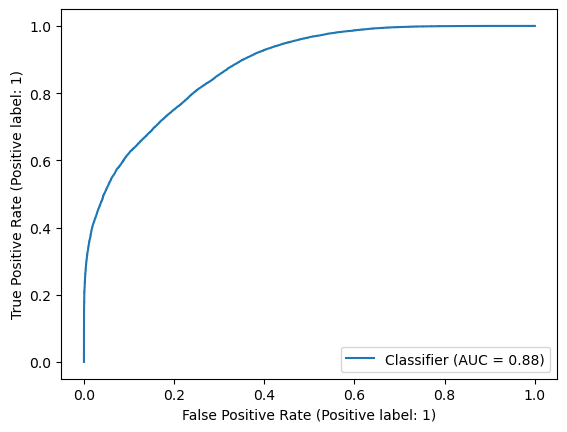

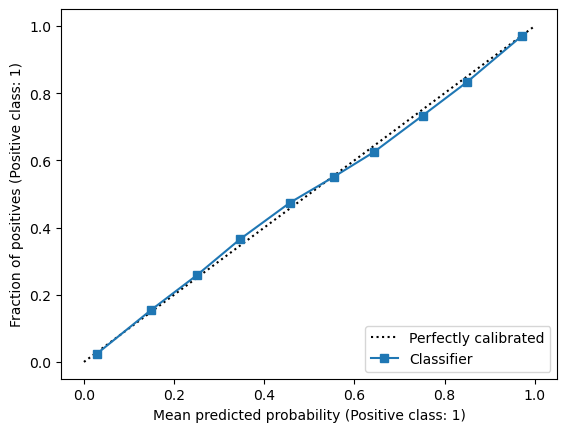

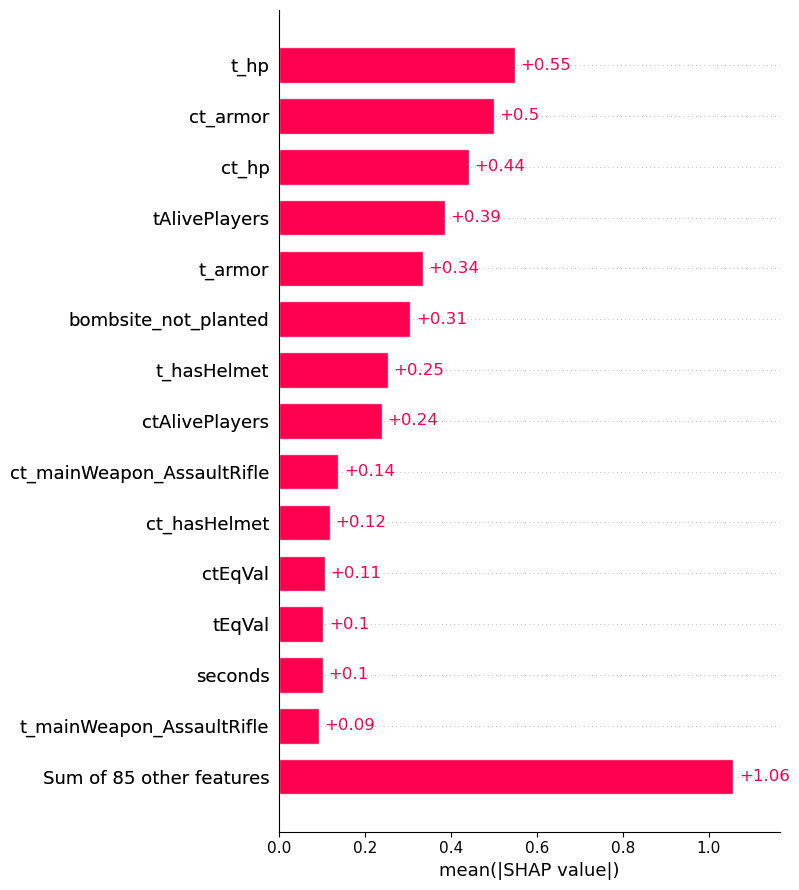

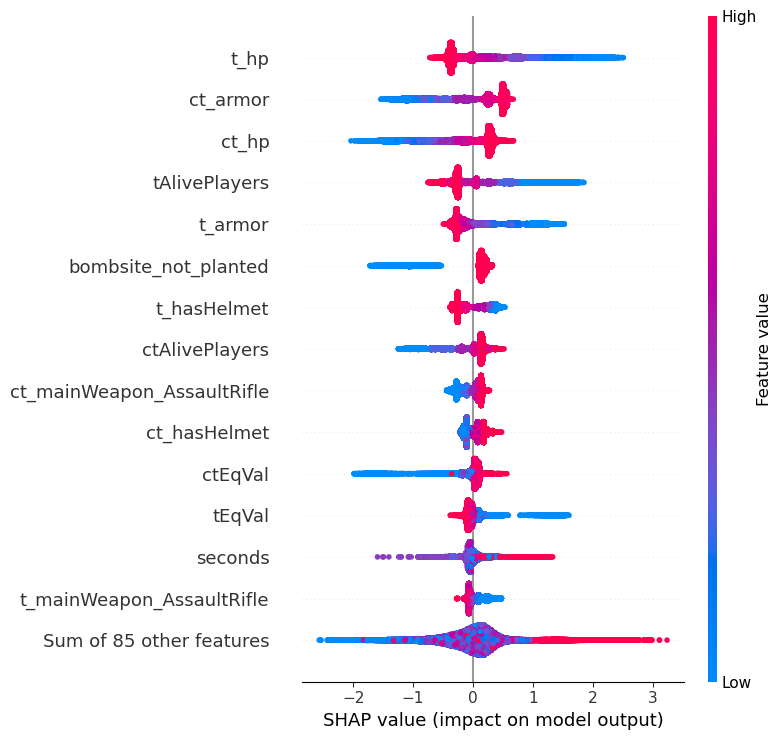

In [30]:
run_name = "XGB - ESTA 10 samples"
additional_description = "XGB ESTA 10 samples"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_xgb.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_xgb.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = X_train.columns.tolist()
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        os.makedirs('artifacts', exist_ok=True)
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        os.makedirs('models', exist_ok=True)
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_xgb, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [31]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [32]:
results = []
y_true = test_y
y_pred = model_xgb.predict_proba(test_df.drop("filename", axis="columns"))[:, 1]
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.45932023140056866,
 'LogLoss (future)': 0.46348700620840916,
 'LogLoss (past)': 0.455434969999371,
 'AUC-ROC (all)': 0.8540136952848626,
 'AUC-ROC (future)': 0.8525684210641153,
 'AUC-ROC (past)': 0.8546503468562872}

# All dataset

In [33]:
groupped = df.groupby(['demoId'])
samples_indexes = groupped.indices
len(samples_indexes)

1558

In [34]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.8*maps), replace=False)
train_indexes = np.array([])
test_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i not in train_ind:
        test_indexes = np.concatenate((test_indexes, samples_indexes[key]))

test_indexes.shape

(1500668,)

In [35]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(train_ind, size=int(0.875*train_ind.size), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, samples_indexes[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, samples_indexes[key]))

train_indexes.shape, valid_indexes.shape

((5226658,), (2237640,))

In [36]:
X = df.drop(['demoId', 'roundNum'], axis='columns')
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()

In [37]:
y.value_counts()

1    3875902
0    3588396
Name: winningSideCT, dtype: int64

In [38]:
X_train, X_test, y_train, y_test = X.iloc[train_indexes], X.iloc[test_indexes], y.iloc[train_indexes], y.iloc[test_indexes]
X_val, y_val = X.iloc[valid_indexes], y.iloc[valid_indexes]
X_train.shape, X_val.shape, X_test.shape

((5226658, 99), (2237640, 99), (1500668, 99))

In [39]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.519761
 0    0.480239
 Name: winningSideCT, dtype: float64,
 1    0.518086
 0    0.481914
 Name: winningSideCT, dtype: float64,
 1    0.511272
 0    0.488728
 Name: winningSideCT, dtype: float64)

In [41]:
parameters = {
    "max_leaves": Integer(0, 70),
    "max_depth": Integer(2, 80),
    "n_estimators": Integer(100, 1300),
    "subsample": Real(0.6, 1),
}

opt = BayesSearchCV(xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0),
                    search_spaces=parameters,
                    scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True, eps=1e-7),
                    n_iter=50,
                    fit_params={"eval_set": [(X_val, y_val)]},
                    cv=StratifiedKFold(n_splits=3),
                    n_jobs=3,
                    verbose=1,
                    random_state=42
                   )
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=0, grow_policy=None,
                                      importance_ty...
              scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True, eps=1e-07),
              search_spaces={'max_depth': Integer(low=2, high=80, prior='uniform', transform='normalize'),
                             'max_leaves': Integer(low=0, high=70, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1300, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize')},
              verbose=1)

In [42]:
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaves,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
42,448.918052,1.866113,23.317698,0.276074,80,0,833,0.943381,"{'max_depth': 80, 'max_leaves': 0, 'n_estimato...",-1.022476,-0.998063,-1.016665,-1.012401,0.010412,50
41,429.015672,1.594708,31.390274,0.554496,19,0,1300,0.6,"{'max_depth': 19, 'max_leaves': 0, 'n_estimato...",-0.998668,-0.978612,-0.985162,-0.987480,0.008351,49
13,321.267455,1.708389,11.284687,0.470524,61,0,276,0.984622,"{'max_depth': 61, 'max_leaves': 0, 'n_estimato...",-0.934414,-0.910602,-0.926010,-0.923675,0.009860,48
35,185.611063,2.279001,5.337773,0.272813,29,0,100,0.60331,"{'max_depth': 29, 'max_leaves': 0, 'n_estimato...",-0.771932,-0.758242,-0.766295,-0.765490,0.005618,47
40,110.536540,0.125385,9.433137,0.067907,17,64,1300,0.681477,"{'max_depth': 17, 'max_leaves': 64, 'n_estimat...",-0.637881,-0.637273,-0.630766,-0.635307,0.003220,46
11,132.621373,0.138976,8.696192,0.011599,28,58,1185,0.655398,"{'max_depth': 28, 'max_leaves': 58, 'n_estimat...",-0.610001,-0.606234,-0.602356,-0.606197,0.003121,45
44,85.107085,0.067677,7.593276,0.045632,57,70,943,0.6,"{'max_depth': 57, 'max_leaves': 70, 'n_estimat...",-0.595562,-0.604974,-0.596020,-0.598852,0.004333,44
0,130.463754,0.364606,8.331124,0.176028,34,51,1219,0.72632,"{'max_depth': 34, 'max_leaves': 51, 'n_estimat...",-0.602713,-0.600979,-0.592582,-0.598758,0.004424,43
22,99.149967,0.131216,8.519844,0.019537,40,45,1293,0.923822,"{'max_depth': 40, 'max_leaves': 45, 'n_estimat...",-0.601397,-0.592381,-0.594433,-0.596070,0.003858,42
15,95.475083,0.155339,7.186637,0.042553,6,70,998,1.0,"{'max_depth': 6, 'max_leaves': 70, 'n_estimato...",-0.585888,-0.594961,-0.583807,-0.588219,0.004843,41


In [43]:
model_xgb = opt.best_estimator_
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


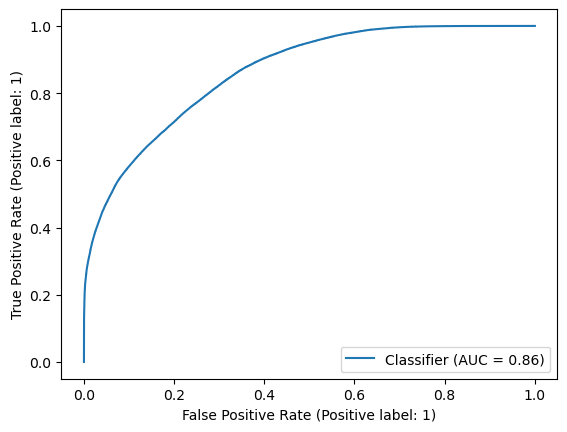

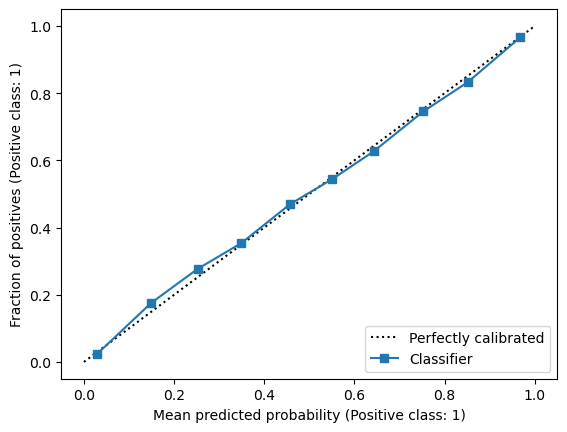

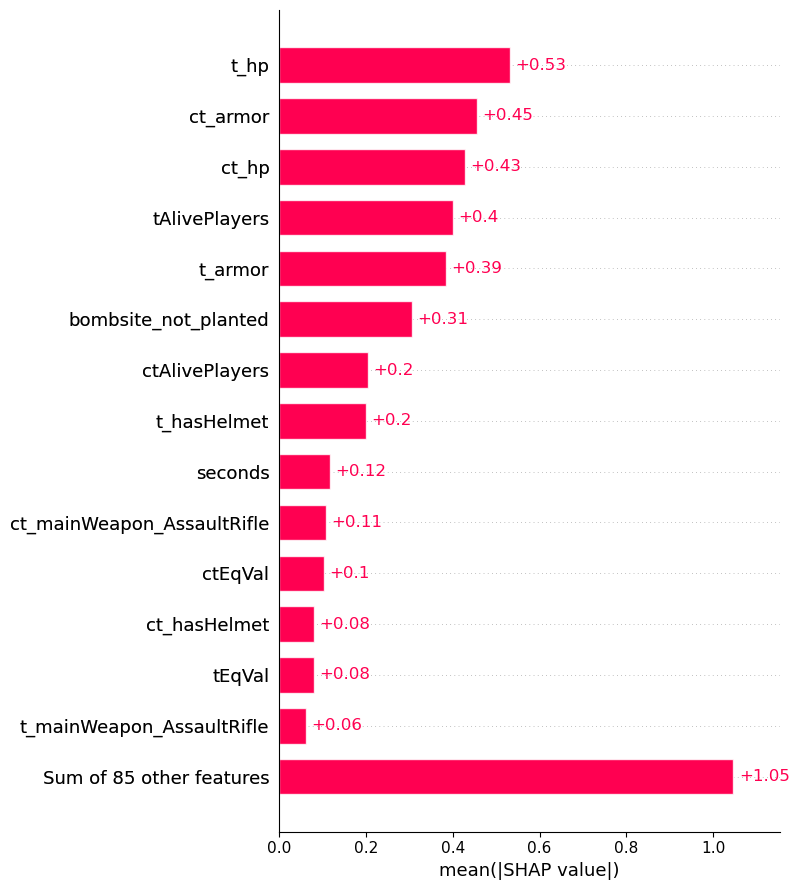

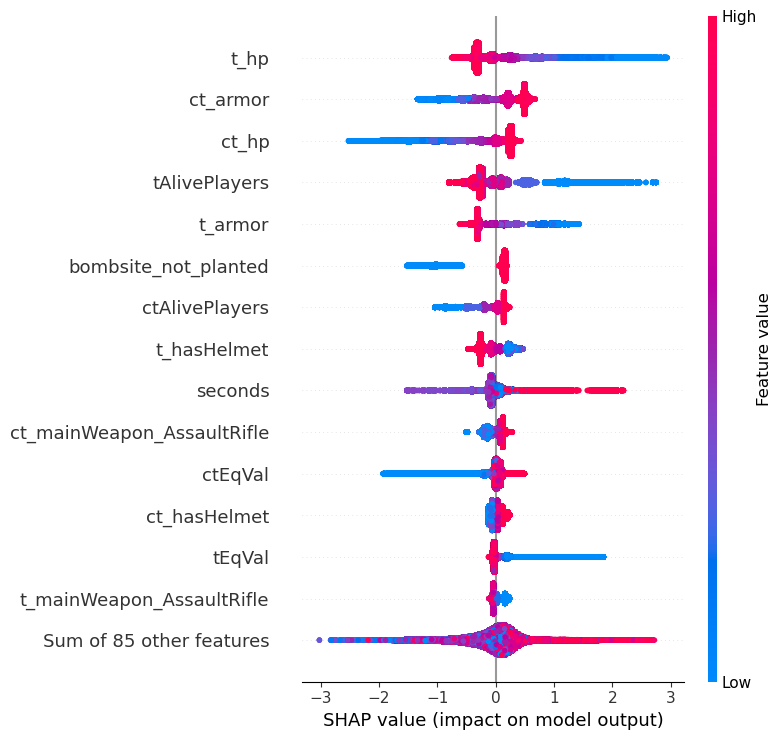

In [44]:
run_name = "XGB - ESTA All Dataset"
additional_description = "XGB ESTA All Dataset"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_xgb.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_xgb.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = X_train.columns.tolist()
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        os.makedirs('artifacts', exist_ok=True)
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        os.makedirs('models', exist_ok=True)
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_xgb, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [45]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [46]:
results = []
y_true = test_y
y_pred = model_xgb.predict_proba(test_df.drop("filename", axis="columns"))[:, 1]
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.4558664080584027,
 'LogLoss (future)': 0.4568234438041909,
 'LogLoss (past)': 0.4549740310488077,
 'AUC-ROC (all)': 0.8558888578447074,
 'AUC-ROC (future)': 0.8569448850516291,
 'AUC-ROC (past)': 0.8544339029146795}